## Weather Forecasting Using Machine Learning:

In [200]:
from meteostat import Point, Daily
from datetime import datetime
import pandas as pd
import numpy as np

In [202]:
df=pd.read_csv("delhi_weather_forecast_ready.xls")
df.head()

,date_time,temperature,tmin,tmax,precipitation,wind_speed,pressure,forecasted_temperature,precipitation_probability,forecasted_precip_prob,weather_condition,forecasted_condition,month,day_of_year,season,is_monsoon
0,2015-01-01,14.9,8.8,21.6,0.0,6.1,1008.3,14.7,0.000000,0.033355,clear,rainy,1,1,0,0
1,2015-01-02,14.7,10.2,21.6,5.1,6.1,1008.3,15.0,0.033355,0.046435,rainy,rainy,1,2,0,0
2,2015-01-03,15.0,20.7,16.8,7.1,6.1,1008.3,14.2,0.046435,0.000000,rainy,clear,1,3,0,0
3,2015-01-04,14.2,10.0,19.0,0.0,8.6,1008.3,13.9,0.000000,0.000000,clear,clear,1,4,0,0
4,2015-01-05,13.9,7.8,20.7,0.0,6.1,1008.3,12.0,0.000000,0.000000,clear,clear,1,5,0,0


In [204]:
# Step 1: Get Historical Data

location = Point(28.6139, 77.2090)  # Delhi
start = datetime(2015, 1, 1)  
end = datetime(2023, 12, 31)

data = Daily(location, start, end)
df = data.fetch().reset_index()

In [206]:
# Step 2: Clean + Basic Processing
df.rename(columns={
    'time': 'date_time',
    'tavg': 'temperature',
    'prcp': 'precipitation',
    'wspd': 'wind_speed',
    'pres': 'pressure'
}, inplace=True)

In [208]:
# Drop unnecessary columns
df = df[['date_time', 'temperature', 'tmin', 'tmax', 'precipitation', 'wind_speed', 'pressure']]

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)


In [210]:
# Step 3: Add future targets
df['forecasted_temperature'] = df['temperature'].shift(-1)

In [212]:
# Simulate precipitation probability (normalize past precip values)
max_precip = df['precipitation'].max()
df['precipitation_probability'] = df['precipitation'] / (max_precip + 0.001)
df['forecasted_precip_prob'] = df['precipitation_probability'].shift(-1)


In [214]:
# Simulate weather condition
df['weather_condition'] = np.where(df['precipitation'] > 1.0, 'rainy', 'clear')
df['forecasted_condition'] = df['weather_condition'].shift(-1)


In [216]:
# Remove last row (due to shifting)
df.dropna(inplace=True)

In [218]:
# Additional Feature Engineering
# Month and Day of Year
df['month'] = df['date_time'].dt.month
df['day_of_year'] = df['date_time'].dt.dayofyear

In [220]:
# Define season (basic logic)
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9]:
        return 'monsoon'
    else:
        return 'autumn'

In [222]:
df['season'] = df['month'].apply(get_season)

In [224]:
# Convert season to numeric for model
df['season'] = df['season'].map({'winter': 0, 'summer': 1, 'monsoon': 2, 'autumn': 3})


In [226]:
# Add binary feature: Is Monsoon?
df['is_monsoon'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8, 9] else 0)


In [228]:
# Save for next phase
df.to_csv("delhi_weather_forecast_ready.csv", index=False)

df.head()

,date_time,temperature,tmin,tmax,precipitation,wind_speed,pressure,forecasted_temperature,precipitation_probability,forecasted_precip_prob,weather_condition,forecasted_condition,month,day_of_year,season,is_monsoon
0,2015-01-01,14.9,8.8,21.6,0.0,6.1,1008.3,14.7,0.000000,0.033355,clear,rainy,1,1,0,0
1,2015-01-02,14.7,10.2,21.6,5.1,6.1,1008.3,15.0,0.033355,0.046435,rainy,rainy,1,2,0,0
2,2015-01-03,15.0,20.7,16.8,7.1,6.1,1008.3,14.2,0.046435,0.000000,rainy,clear,1,3,0,0
3,2015-01-04,14.2,10.0,19.0,0.0,8.6,1008.3,13.9,0.000000,0.000000,clear,clear,1,4,0,0
4,2015-01-05,13.9,7.8,20.7,0.0,6.1,1008.3,12.0,0.000000,0.000000,clear,clear,1,5,0,0


In [230]:
# Step 4: Train Regression & Classification Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

In [232]:
# Define Features and Targets

features = ['temperature', 'tmin', 'tmax', 'wind_speed', 'pressure', 'precipitation',
            'month', 'day_of_year', 'season', 'is_monsoon']

target_reg_temp = 'forecasted_temperature'
target_reg_precip = 'forecasted_precip_prob'
target_cls = 'forecasted_condition'

In [234]:
# Split Data
X = df[features]

In [236]:
# For Regression (Temperature) 
y_temp = df[target_reg_temp]
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y_temp, test_size=0.2, random_state=42)


In [238]:
# -- For Regression (Precipitation Probability) --
y_precip = df[target_reg_precip]
X_train_precip, X_test_precip, y_train_precip, y_test_precip = train_test_split(X, y_precip, test_size=0.2, random_state=42)


In [240]:
# -- For Classification (Weather Condition) --
y_cond = df[target_cls]
X_train_cond, X_test_cond, y_train_cond, y_test_cond = train_test_split(X, y_cond, test_size=0.2, random_state=42)


## Train Models


In [243]:
# Temperature Regressor
reg_temp = RandomForestRegressor(n_estimators=100, random_state=42)
reg_temp.fit(X_train_temp, y_train_temp)

RandomForestRegressor(random_state=42)

In [244]:
print(df.columns)

Index(['date_time', 'temperature', 'tmin', 'tmax', 'precipitation',
       'wind_speed', 'pressure', 'forecasted_temperature',
       'precipitation_probability', 'forecasted_precip_prob',
       'weather_condition', 'forecasted_condition', 'month', 'day_of_year',
       'season', 'is_monsoon'],
      dtype='object')


In [247]:
# Features for predicting forecasted_precip_prob
X_precip = df[['temperature', 'tmin', 'tmax', 'precipitation',
                         'wind_speed', 'pressure', 'month',
                         'day_of_year', 'season', 'is_monsoon']]

# Target variable
y_precip = df['forecasted_precip_prob']

# Train-test split
X_train_precip, X_test_precip, y_train_precip, y_test_precip = train_test_split(
    X_precip, y_precip, test_size=0.2, random_state=42
)


In [249]:
# Precipitation Probability Regressor
reg_precip = RandomForestRegressor(n_estimators=100, random_state=42)
reg_precip.fit(X_train_precip, y_train_precip)

RandomForestRegressor(random_state=42)

In [250]:
# 8. Oversample Rainy Data (Classification)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_cond, y_train_cond)

# Weather Condition Classifier with balanced weights
cls_cond = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
cls_cond.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

##  Evaluate Models

In [253]:
# Temperature
from sklearn.metrics import root_mean_squared_error
rmse_temp = root_mean_squared_error(y_test_temp, y_pred_temp)

In [256]:
# Precipitation Probability
rmse_precip = root_mean_squared_error(y_test_precip, y_pred_precip)

In [258]:
# Weather Condition
y_pred_cond = cls_cond.predict(X_test_cond)
acc_cond = accuracy_score(y_test_cond, y_pred_cond)

In [260]:
# Print Results

print(f"\n✅ Regression - Temperature:")
print(f"RMSE: {rmse_temp:.2f} °C")

print(f"\n✅ Regression - Precipitation Probability:")
print(f"RMSE: {rmse_precip:.3f}")

print(f"\n✅ Classification - Weather Condition (Balanced):")
print(f"Accuracy: {acc_cond:.2%}")
print(classification_report(y_test_cond, y_pred_cond))



✅ Regression - Temperature:
RMSE: 1.47 °C

✅ Regression - Precipitation Probability:
RMSE: 0.053

✅ Classification - Weather Condition (Balanced):
Accuracy: 89.67%
              precision    recall  f1-score   support

       clear       0.92      0.97      0.94       582
       rainy       0.59      0.34      0.43        76

    accuracy                           0.90       658
   macro avg       0.75      0.66      0.69       658
weighted avg       0.88      0.90      0.88       658



In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

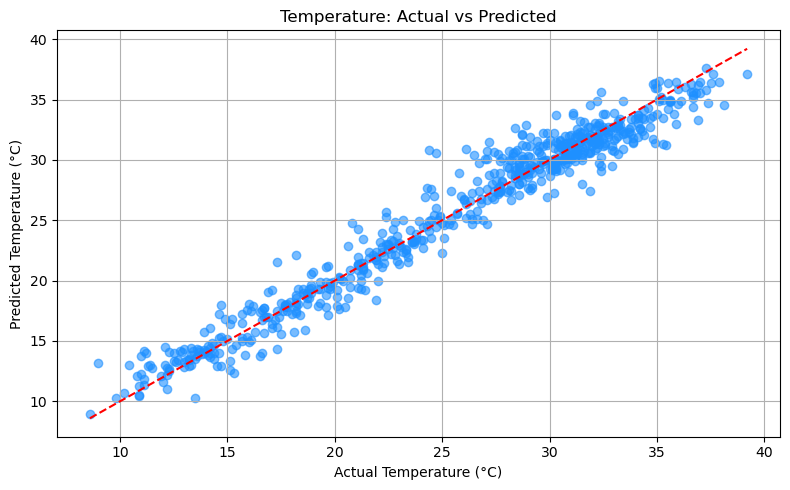

In [264]:
# 1. Predicted vs Actual: Temperature
plt.figure(figsize=(8, 5))
plt.scatter(y_test_temp, y_pred_temp, alpha=0.6, color='dodgerblue')
plt.plot([y_test_temp.min(), y_test_temp.max()], [y_test_temp.min(), y_test_temp.max()], 'r--')
plt.title("Temperature: Actual vs Predicted")
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

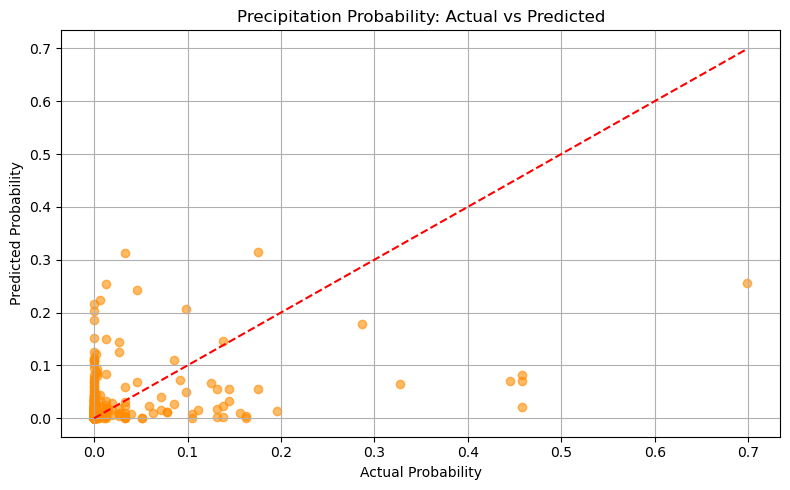

In [266]:
# 2. Predicted vs Actual: Precipitation Probability
plt.figure(figsize=(8, 5))
plt.scatter(y_test_precip, y_pred_precip, alpha=0.6, color='darkorange')
plt.plot([y_test_precip.min(), y_test_precip.max()], [y_test_precip.min(), y_test_precip.max()], 'r--')
plt.title("Precipitation Probability: Actual vs Predicted")
plt.xlabel("Actual Probability")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

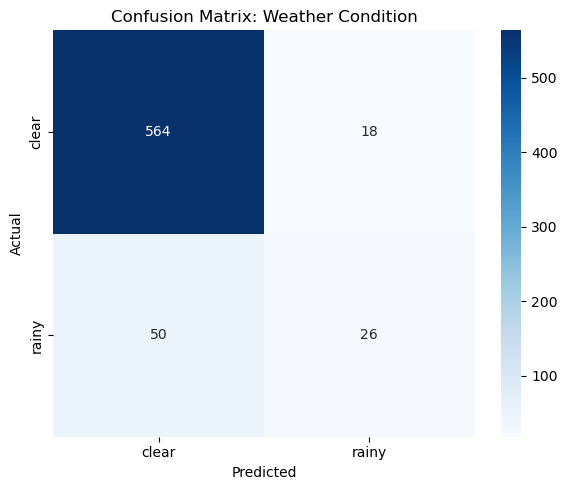

In [268]:
# 3. Confusion Matrix: Weather Condition

cm = confusion_matrix(y_test_cond, y_pred_cond, labels=cls_cond.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=cls_cond.classes_,
            yticklabels=cls_cond.classes_)
plt.title("Confusion Matrix: Weather Condition")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

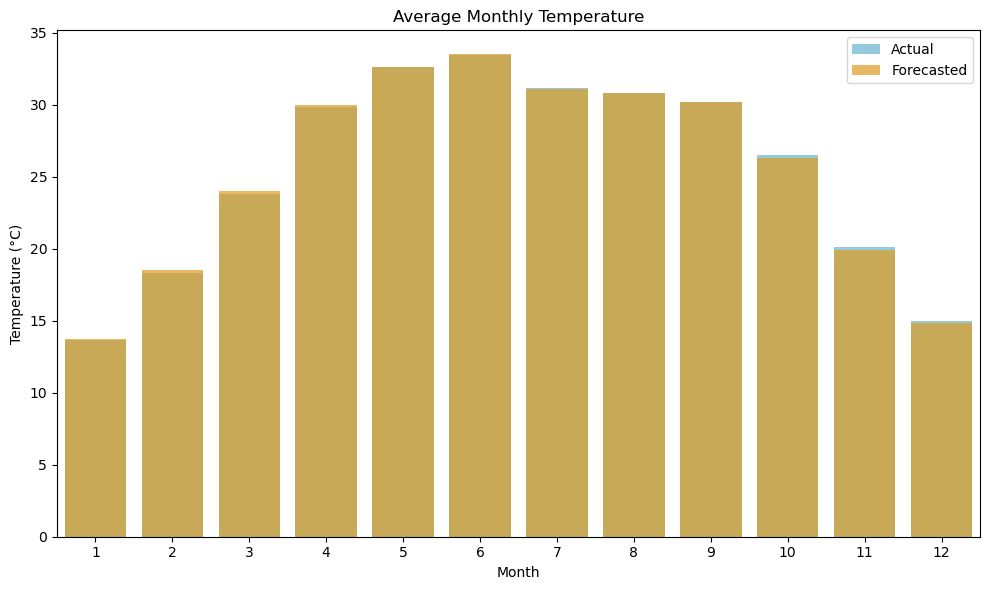

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
monthly_avg = df.groupby('month')[['temperature', 'forecasted_temperature']].mean().reset_index()
monthly_avg = monthly_avg.sort_values(by='month')

sns.barplot(data=monthly_avg, x='month', y='temperature', color='skyblue', label='Actual')
sns.barplot(data=monthly_avg, x='month', y='forecasted_temperature', color='orange', label='Forecasted', alpha=0.7)

plt.title("Average Monthly Temperature")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()


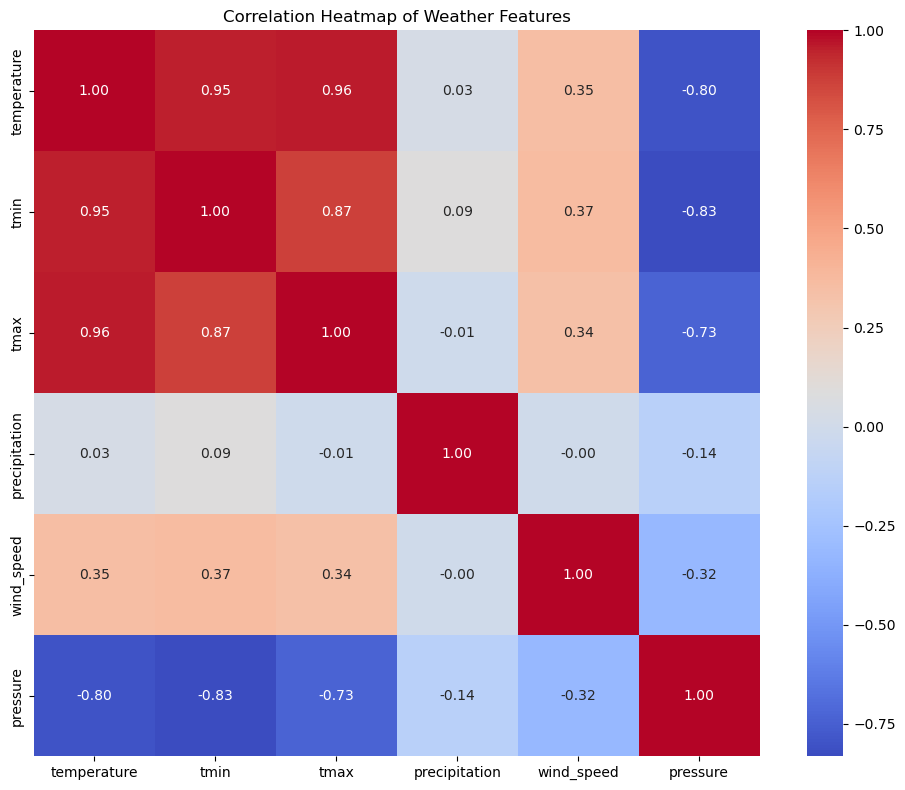

In [272]:
plt.figure(figsize=(10, 8))
corr = df[['temperature', 'tmin', 'tmax', 'precipitation', 'wind_speed', 'pressure']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Weather Features")
plt.tight_layout()
plt.show()


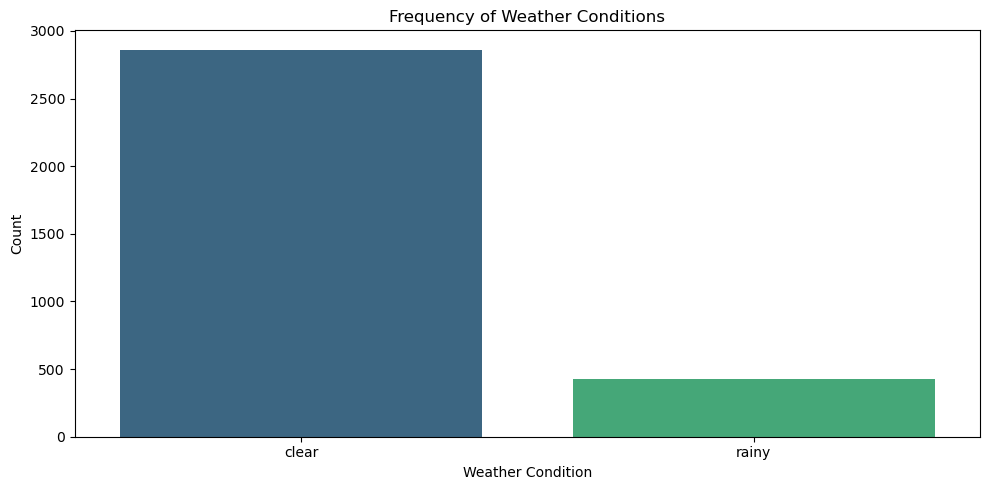

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x='weather_condition',
    order=df['weather_condition'].value_counts().index,
    hue='weather_condition',
    palette='viridis',
    legend=False
)
plt.title("Frequency of Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
